# RNN-based classification of neutrino detection signals

## 1. Load libraries and classes

### External libraries

In [28]:
import numpy as np
import pandas as pd
import importlib
import torch
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [4]:
# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### For Google Colab environment

In [6]:
# IF RUNNING IN GOOGLE COLAB:
# Connect to Google Drive (so we do not have to download the data files each time the runtime resets)
from google.colab import drive
drive.mount("/content/gdrive")

# Where to fetch data files
data_path = "/content/gdrive/MyDrive/Colab Notebooks/Data/"

Mounted at /content/gdrive


In [19]:
# IF RUNNING IN GOOGLE COLAB:
# Copy class files (.py files) to the local Notebook folder in Colab, so we can import them below
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_RNN.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_LSTM.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_GRU.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_Continuous_LSTM.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Trainer.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/RNNBinaryClassifier.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/BinaryClassificationPreprocessor.py" .

#### When running locally

In [20]:
# Fetch data directly from the hard drive
#data_path = "C:/DataProject15ECT/ARIANNA_100_1CH/"

### Definition of different RNN models

In [21]:
# Make sure we get the latest versions
importlib.reload(importlib.import_module("Model_RNN"))
importlib.reload(importlib.import_module("Model_LSTM"))
importlib.reload(importlib.import_module("Model_GRU"))
importlib.reload(importlib.import_module("Model_Continuous_LSTM"))

from Model_RNN import Model_RNN
from Model_LSTM import Model_LSTM
from Model_GRU import Model_GRU
from Model_Continuous_LSTM import Model_Continuous_LSTM

print("Loaded.")

Loaded.


### Modules for mini-batch training, data preprocessing and binary classification

In [22]:
# Make sure we get the latest versions
importlib.reload(importlib.import_module("Trainer"))
importlib.reload(importlib.import_module("BinaryClassificationPreprocessor"))
importlib.reload(importlib.import_module("RNNBinaryClassifier"))

from Trainer import Trainer
from BinaryClassificationPreprocessor import BinaryClassificationPreprocessor
from RNNBinaryClassifier import RNNBinaryClassifier
print("Loaded.")

Loaded.


## 2. Univariate batch processing (ARIANNA 1CH 100 dataset)

### Data preparation

#### Load data from the current environment

In [32]:
# Load ARIANNA 100 timesteps 1 channel dataset
# ** Note that path must be set according to the current enviroment **
fullpath = data_path + "ARIANNA_100_1CH/"
noise = np.load(fullpath + "trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,6):
    noise = np.vstack((noise,np.load(fullpath + f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load(fullpath + "trimmed100_data_signal_3.6SNR_1ch_0000.npy")
signal = signal.reshape(signal.shape[0], 1, signal.shape[1])
noise = noise.reshape(noise.shape[0], 1, noise.shape[1])
print("Signal events:", signal.shape)
print("Noise events:", noise.shape)

X_in = signal
Y_in = noise

Signal events: (99997, 1, 100)
Noise events: (600000, 1, 100)


In [ ]:
# Try pruning parts of each record - NOT IN USE currently
#X_in = X_in[:,:,30:60]
#Y_in = Y_in[:,:,30:60]
#print(X_in.shape, Y_in.shape)

### Training

In [33]:
pp = BinaryClassificationPreprocessor()
cl = RNNBinaryClassifier(device)

In [40]:
cl.load_data(pp.load_data_by_class(X_in, Y_in, val_ratio=0.2, test_ratio=0.2))

Process 1: using 99997 time series with 1 features, of length 100
Process 2: using 600000 time series with 1 features, of length 100
Preprocessed datasets:
Train: (419997, 1, 100), range [-425.05752820212456, 483.51428094078705]
Validation: (140000, 1, 100), range [-409.13783961922644, 261.93996374558054]
Test: (140000, 1, 100), range [-321.9979015484657, 269.83015601086936]



Number of trainable parameters in the model: 421
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[1/10] Training loss: 0.0463	 Validation loss: 0.0142
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[2/10] Training loss: 0.0119	 Validation loss: 0.0120
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[3/10] Training loss: 0.0107	 Validation loss: 0.0113
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[4/10] Training loss: 0.0100	 Validation loss: 0.0108
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[5/10] Training loss: 0.0096	 Validation loss: 0.0105
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[6/10] Training loss: 0.0092	 Validation loss: 0.0102
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[7/10] Training loss: 0.0089	 Validation los

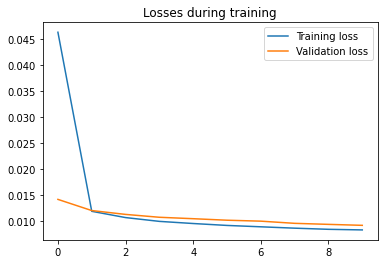

Training time: 154.8055384159088


In [41]:
# Start training
n_features = 1
output_dim = 1  
hidden_size = 6
n_hidden = 2
dropout = 0.1

model = Model_GRU(n_features, 1, hidden_size, n_hidden, dropout, device)
print("\nNumber of trainable parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))
t0 = time.time()
best_model = cl.train(model, n_features=n_features, n_epochs=20, lr=0.002, batch_size=100)
print("Training time:", time.time() - t0)

### Evaluation

In [42]:
cl.run_evaluation(batch_size=100)

In [43]:
r_value = 0.5
metrics, _ = cl.classify_with_threshold(r_value=r_value)
print("r_value:", r_value)
print("Accuracy:", metrics[0], "\nPrecision:", metrics[1][0], "\nRecall:", metrics[1][1], "\nF1:", metrics[1][2])

r_value: 0.5
Accuracy: 0.9980857142857142 
Precision: 0.9967234600262124 
Recall: 0.9898378053664397 
F1: 0.993268699452454


Total signal events: 19976 Total noise events: 120024


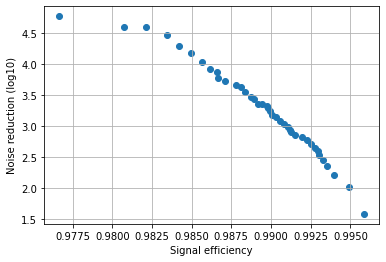

In [44]:
cl.plot_signal_eff_vs_noise_red()

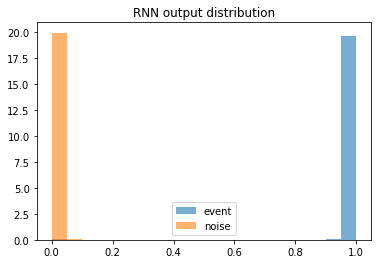

In [45]:
cl.plot_output_distribution()

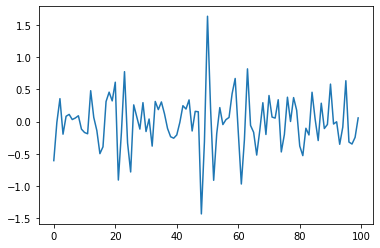

Logit output: [[-7.1191325]]
True label: [[0.]]



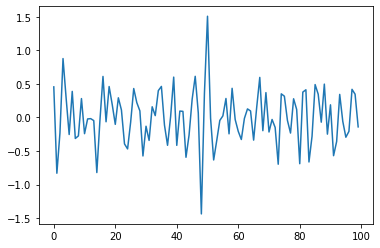

Logit output: [[-7.8415427]]
True label: [[0.]]



In [46]:
cl.plot_samples(n_samples=2)

### Test on ARIANNA 256 timesteps dataset

In [65]:
# Run the trained network on separate part of the ARIANNA 256 timesteps 1 channel dataset (batch mode)
path = "/content/gdrive/MyDrive/Colab Notebooks/Data/ARIANNA_256_1CH/"
noise_256 = np.load(path + "data_noise_1ch_3.6SNR_0005.npy")
for i in range(6,10):
    if i != 8:
        noise_256 = np.vstack((noise_256,np.load(path + f"data_noise_1ch_3.6SNR_000{i}.npy")))
signal_256 = np.load(path + "data_signal_1ch_0001.npy")
print("Signal events:", signal_256.shape)
print("Noise events:", signal_256.shape)

X_100 = signal_256[:, :, 0:100]
Y_100 = noise_256[:, :, 0:100]
X_merge = np.concatenate((X_100, Y_100), axis=0)
y_merge = np.concatenate((np.ones(len(X_100)), np.zeros(len(Y_100))), axis=0)
print(X_merge.shape, y_merge.shape)
cl.set_test_set(pp.load_test_data(X_merge, y_merge))
cl.run_evaluation(batch_size=100)

Signal events: (21597, 1, 256)
Noise events: (21597, 1, 256)
(421597, 1, 100) (421597,)


## 3. Univariate continuous input (ARIANNA 100 1CH dataset)

### Data preparation (using data loaded previously in section 2) 

In [47]:
# Transform the original data into a continous input with labels for each datapoint
print("Input shape:", signal.shape, noise.shape)
start_event = 40
end_event = 80
N_FEATURES = signal.shape[1]
WINDOW_LENGTH = signal.shape[2]  # Must be the same for both signal events and noise events
N_SERIES = len(signal) + len(noise)
N_STEPS = N_SERIES * WINDOW_LENGTH

series = []
labels = []
for i in range(len(signal)):
    series.append(signal[i,:,:])

    # Add corresponding labels for each timestep of the signal event
    labels.append(np.concatenate((np.zeros(start_event),                  # noise part
                                  np.ones(end_event - start_event),       # signal part
                                  np.zeros(WINDOW_LENGTH - end_event))))  # noise part

for i in range(len(noise)):
    series.append(noise[i,:,:])
    labels.append(np.zeros(WINDOW_LENGTH))

print("Series size:", len(series), len(series[0]), len(series[0][0]))

p = np.random.permutation(N_SERIES)
X_data = np.zeros((N_STEPS, N_FEATURES))
y_data = np.zeros(N_STEPS)
pos = 0
for i in range(len(series)):
    j = p[i]   # Random order when concatenating
    L = series[j].shape[1]
    X_data[pos:pos+L,:] = series[j].reshape(-1,1)
    y_data[pos:pos+L] = labels[j]
    pos += L
    
print("Final shape of input and labels:", X_data.shape, y_data.shape)

Input shape: (99997, 1, 100) (600000, 1, 100)
Series size: 699997 1 100
Final shape of input and labels: (69999700, 1) (69999700,)


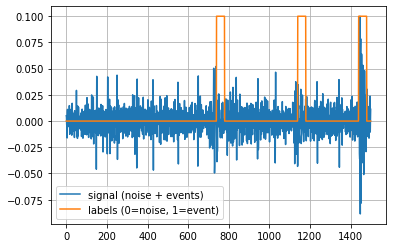

In [48]:
# Plot a random sample of the transformed data for visual verification
L = 1500
start = np.random.randint(len(X_data)-L)//100 * 100
plt.plot(X_data[start:start+L, 0], label="signal (noise + events)")
plt.plot(y_data[start:start+L]/10.0, label="labels (0=noise, 1=event)")
plt.legend()
plt.grid()
plt.show()

In [49]:
pp2 = BinaryClassificationPreprocessor()
SEQUENCE_LENGTH = 50000 # Number of timesteps of one item in one batch
WINDOW_LENGTH = 1  # This should always be 1 currently (i.e. we want to have one output value for each timestep)
d = pp2.load_continuous_data(X_data, y_data, SEQUENCE_LENGTH, WINDOW_LENGTH, test_ratio=0.2)

(1399, 1, 50000) (1399, 50000)
Preprocessed datasets:
Train: (839, 1, 50000), range [-437.62215285692673, 442.63226798938337]
Validation: (280, 1, 50000), range [-441.5247512523711, 502.2461361232881]
Test: (280, 1, 50000), range [-387.63390499057783, 447.0619927654331]


### Training

In [50]:
cl2 = RNNBinaryClassifier(device)
cl2.load_data(d)

Number of trainable parameters in the model: 117
0...4...8...12...16...20...24...28...32...
[1/10] Training loss: 0.3334	 Validation loss: 0.1527
Best so far, saving
0...4...8...12...16...20...24...28...32...
[2/10] Training loss: 0.1196	 Validation loss: 0.1049
Best so far, saving
0...4...8...12...16...20...24...28...32...
[3/10] Training loss: 0.1024	 Validation loss: 0.0996
Best so far, saving
0...4...8...12...16...20...24...28...32...
[4/10] Training loss: 0.0968	 Validation loss: 0.0941
Best so far, saving
0...4...8...12...16...20...24...28...32...
[5/10] Training loss: 0.0932	 Validation loss: 0.1065
0...4...8...12...16...20...24...28...32...
[6/10] Training loss: 0.1020	 Validation loss: 0.0978
0...4...8...12...16...20...24...28...32...
[7/10] Training loss: 0.0959	 Validation loss: 0.0944
0...4...8...12...16...20...24...28...32...
[8/10] Training loss: 0.0926	 Validation loss: 0.0907
Best so far, saving
0...4...8...12...16...20...24...28...32...
[9/10] Training loss: 0.0887	 Va

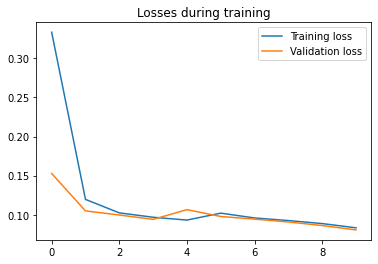

Training time: 69.51976370811462


In [ ]:
n_features = 1  # Univariate
output_dim = 1  
hidden_size = 4
n_hidden = 1
dropout = 0.0

model2 = Model_Continuous_LSTM(n_features, 1, hidden_size, n_hidden, dropout, device)
print("Number of trainable parameters in the model:", sum(p.numel() for p in model2.parameters() if p.requires_grad))
t0 = time.time()
best_model2 = cl2.train(model2, n_features=n_features, n_epochs=10, lr=0.05, use_scheduler=False, batch_size=20)  # Small batch size seems to work best here
print("Training time:", time.time() - t0)

### Evaluation

In [ ]:
cl2.run_evaluation(batch_size=10)

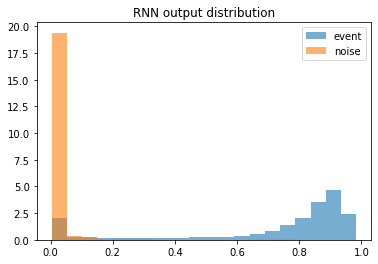

In [ ]:
cl2.plot_output_distribution()

In [ ]:
cl2.classify_with_threshold(r_value=0.5)

([0.97484925,
  (0.816606307176429, 0.8043364420727146, 0.8104249357266733, None)],
 array([False, False, False, ..., False, False, False]))

#### Classification of each 100-step sequence as either being a signal event or a noise event 

In [ ]:
def find_batch(loader, N, start):
    batch_length = N // len(loader)
    count = 0
    for x, y in loader:
        if count + batch_length < start:
            count += batch_length
        else:
            break   # Loop until we find the batch which the desired start index belongs to
    return count, x, y

In [ ]:
def run_detection(y_pred, W, threshold):
    # Given the sigmoid step-by-step output from the RNN, apply a threshold to a running average
    # to determine whether we have found a signal event or not
    
    y_pred_avg = np.zeros(len(y_pred))
    for i in range(W, len(y_pred)):
        y_pred_avg[i] = np.mean(y_pred[i-W:i])

    return y_pred_avg > threshold

In [ ]:
def plot_output_for_test_set(classifier, start, L):
    # start = from which timestep in the input sequence the plot should start

    count, x, _ = find_batch(DataLoader(classifier.test_set, batch_size=1, shuffle=False), len(classifier.y_true), start)

    x_input = x.view([1, -1, n_features])[0,0:L,0].numpy()
    # x_input now contains (part of) the relevant part of the input
    y_pred = classifier.sigmoids[count:count+L]
    y_pred_avg = run_detection(y_pred, 20, 0.75)
    y_true = classifier.y_true[count:count+L]
    xs = np.linspace(0, L, num=L)
    
    w, h = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [20, 5]
    print("Starting at index", start)
    plt.plot(xs, x_input, alpha=0.5)
    plt.plot(xs, y_pred)
    plt.plot(xs, y_true)
    plt.plot(xs, y_pred_avg)
    plt.ylim((-1.5, 1.5))
    plt.xticks(np.arange(0,L,200))
    plt.grid()
    plt.show()
    plt.rcParams['figure.figsize'] = [w, h]

Starting at index 220844


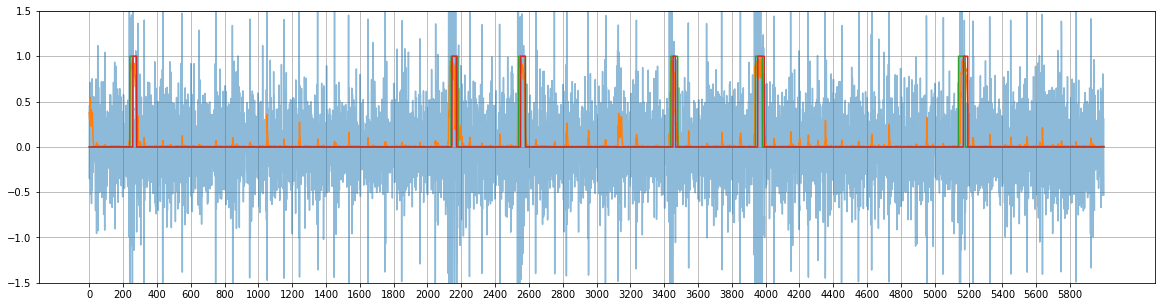

In [ ]:
plot_output_for_test_set(cl2, np.random.randint(1000000), 6000)

In [ ]:
# Calculate metrics based on detecting continously and classifying each of the original 100-timestep batches in the test dataset
y_pred_steps = run_detection(cl2.sigmoids[0:2000000], 3, 0.9)

In [ ]:
N_WINDOWS = len(y_pred_steps)//100
print(N_WINDOWS)
y_true = np.zeros(N_WINDOWS)
y_pred = np.zeros(N_WINDOWS)
for window in range(N_WINDOWS):
    start = window * 100
    end = start + 100
    y_true[window] = cl2.y_true[start + 50]
    y_pred[window] = np.sum(y_pred_steps[start:end]) > 0.0

20000


In [ ]:
tp = np.sum((y_pred == True) & (y_true == True))
fp = np.sum((y_pred == True) & (y_true == False))
tn = np.sum((y_pred == False) & (y_true == False))
fn = np.sum((y_pred == False) & (y_true == True))
print(tp, fp, tn, fn)
print("Signal eff.:", tp/(tp + fn))
print("Noise red.:", np.log10(1/(1-tn/(tn + fp))))

3146 16 16627 211
Signal eff.: 0.9371462615430444
Noise red.: 3.017111630525494


In [ ]:
# Select some random examples, classify and show the signal for visual verification
dl = DataLoader(cl2.test_set, batch_size=1, shuffle=True)
r_value = 0.5
count = 0
start = 5100
L = 500
output_start = start // WINDOW_LENGTH
output_length = L // WINDOW_LENGTH 

w, h = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]

for x, y in dl:
    x_input = x.view([1, -1, n_features]).to(device)
    t0 = time.time()
    logit = best_model2(x_input)  # Here the number of outputs is equal to SEQUENCE_LENGTH // WINDOW_LENGTH
    print((time.time() - t0)*1e6/x_input.size()[1], "microseconds per time step")
    y_pred = torch.sigmoid(logit[0,output_start:output_start+output_length,0]).detach().cpu().numpy()
    y_true = y[0,output_start:output_start+output_length,0].detach().cpu().numpy()
    input = x_input[0,start:start+L,0].detach().cpu().numpy()
    plt.plot(input.clip(-1.0, 1.0), alpha=0.5)
    plt.plot(np.linspace(0, L, num=output_length), y_pred)
    plt.plot(np.linspace(0, L, num=output_length), y_true)
    plt.grid()
    plt.show()
    count += 1
    if count > 4:
        break
plt.rcParams['figure.figsize'] = [w, h]

In [ ]:
# Run on a continuous signal (test data)
dl = DataLoader(cl2.test_set, shuffle=True)
X, y = iter(dl).next()    # Get one series of SEQUENCE_LENGTH time steps
n_features = 1
start = 0000
L = 5000
y_pred = np.zeros(L//WINDOW_LENGTH)
detected = np.zeros(L//WINDOW_LENGTH)
y_true = y[0,start//WINDOW_LENGTH:(start+L)//WINDOW_LENGTH,0].detach().cpu().numpy()
best_model2.step_by_step_mode(True)
t0 = time.time()
width = 0.0
deadtime = 0
tp = 0
fp = 0
fn = 0
errors = []
signal_event = False
for w in range(L//WINDOW_LENGTH):  # Run in "batches" of length WINDOW_LENGTH
    x0 = start + w * WINDOW_LENGTH # First timestep of input for this window
    x1 = x0 + WINDOW_LENGTH        # Last timestep of input for this window
    s = torch.sigmoid(best_model2(X[0, :, x0:x1].view([1,-1,n_features]).to(device)))
    y_pred[w] = s

    if y_true[w]:
        signal_event = True
    elif signal_event == True:  # If we are leaving a part where the label is "true"
        signal_event = False
        if deadtime > 0:
            tp += 1     # Ok, successful detection for the current label
        else:
            fn += 1     # No deadtime currently: we did not detect this signal event
            #print("fn at", w)
            errors.append(w)

    if deadtime > 0:   # No detection during deadtime
        deadtime -= 1   
    else:
                
        if y_pred[w] > 0.6:
            width += 1.0
        else:
            width = 0.0
        if width > 10//WINDOW_LENGTH:           # Signal event detected!
            detected[w] = 1.5
            if not y_true[w]:   # Do we have a "true" label at this timestep? 
                fp += 1
                #print("fp at", w)
                errors.append(w)
            width = 0.0
            deadtime = 50//WINDOW_LENGTH

print((time.time() - t0)*1e6/L, "microseconds per time step")
print(tp, fp, fn)
input = X[0][0][start:start+L].detach().cpu().numpy()  ## NOTE: Only one feature is shown
w, h = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(input, alpha=0.5)
xs = np.linspace(0, L, num=L//WINDOW_LENGTH)
plt.plot(xs, y_pred)
plt.plot(xs, y_true)
plt.plot(xs, detected, c='r', alpha=0.5)
plt.ylim((-1.5, 1.5))
plt.grid()
plt.show()

# Plot the input and output around the timesteps where misclassification occurs
width = 100 // WINDOW_LENGTH
for e in errors:
    
    x0 = (start + (e-width) * WINDOW_LENGTH) // 100 * 100  # Ensure we start from the beginning of one of the original sequences
    x1 = (start + (e+width) * WINDOW_LENGTH) // 100 * 100
    y0 = x0 // WINDOW_LENGTH
    y1 = x1 // WINDOW_LENGTH

    print("Showing input from", x0, "to", x1, "and output from", y0, "to", y1)
    input = X[0][0][x0:x1].detach().cpu().numpy()  # NOTE: Only one feature is shown
    w, h = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot(input, alpha=0.5)
    xs = np.linspace(0, x1 - x0, num=2*width)
    plt.plot(xs, y_pred[y0:y1])
    plt.plot(xs, y_true[y0:y1])
    plt.plot(xs, detected[y0:y1], c='r', alpha=0.5)
    plt.ylim((-1.5, 1.5))
    plt.grid()
    plt.show()


plt.rcParams['figure.figsize'] = [w, h]

## 4. Multivariate input (5 channels), batch mode (ARIANNA 256 5CH dataset)

### Data preparation

In [51]:
# Load ARIANNA 5 channels dataset
path = data_path + "ARIANNA_256_5CH/"
noise_5ch = np.load(path + "data_noise_5ch_3.6SNR_0000.npy")
for i in range(1, 3):   # Currently we only use a subset of the available data, to speed up testing
    noise_5ch = np.vstack((noise_5ch, np.load(path + f"data_noise_5ch_3.6SNR_000{i}.npy")))
events_5ch = np.load(path + "data_signal_5ch_0000.npy")
events_5ch.shape, noise_5ch.shape

((100000, 5, 256), (300000, 5, 256))

In [52]:
print("Total number of invalid values (nan) in the dataset:", np.sum(np.isnan(events_5ch)))

Total number of invalid values (nan) in the dataset: 1280


In [53]:
# Remove series with nan values
nan_series = np.isnan(np.sum(np.sum(events_5ch, axis=2), axis=1))
events_5ch = events_5ch[nan_series == False]
events_5ch.shape

(99995, 5, 256)

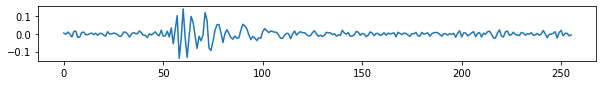

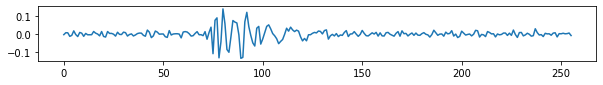

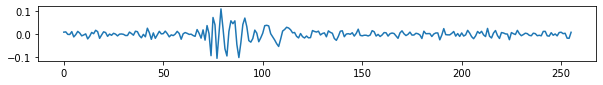

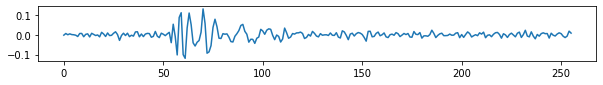

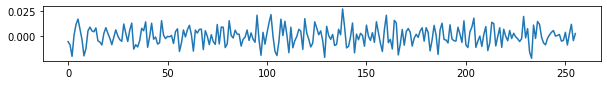

In [54]:
w, h = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 1]
for i in range(5):
  plt.plot(events_5ch[10081][i])
  plt.show()
plt.rcParams['figure.figsize'] = [w, h]

In [55]:
pp5 = BinaryClassificationPreprocessor()
cl5 = RNNBinaryClassifier(device)

In [56]:
cl5.load_data(pp5.load_data_by_class(events_5ch, noise_5ch, val_ratio=0.2, test_ratio=0.2))

Process 1: using 99995 time series with 5 features, of length 256
Process 2: using 300000 time series with 5 features, of length 256
Preprocessed datasets:
Train: (239997, 5, 256), range [-894.5754342298424, 1055.5127956753533]
Validation: (79999, 5, 256), range [-528.3201526054245, 562.9190922781364]
Test: (79999, 5, 256), range [-625.76222446384, 603.0826029629827]


### Training


Number of trainable parameters in the model: 493
0...240...480...720...960...1200...1440...1680...1920...2160...
[1/2] Training loss: 0.2632	 Validation loss: 0.0394
Best so far, saving
0...240...480...720...960...1200...1440...1680...1920...2160...
[2/2] Training loss: 0.0249	 Validation loss: 0.0174
Best so far, saving


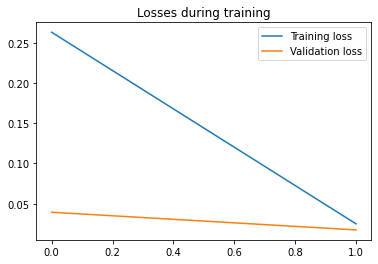

Training time: 23.754971742630005


In [59]:
n_features = 5
output_dim = 1  
hidden_size = 6
n_hidden = 2
dropout = 0.1

model = Model_GRU(n_features, 1, hidden_size, n_hidden, dropout, device)
print("\nNumber of trainable parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))
t0 = time.time()
best_model = cl5.train(model, n_features=n_features, n_epochs=20, lr=0.002, batch_size=100)
print("Training time:", time.time() - t0)

### Evaluation

In [60]:
cl5.run_evaluation()

In [61]:
cl5.classify_with_threshold(r_value=0.5)

([0.9950688360450564,
  (0.9913978494623656, 0.9889249189324021, 0.9901598401598402, None)],
 array([False, False, False, ..., False, False, False]))

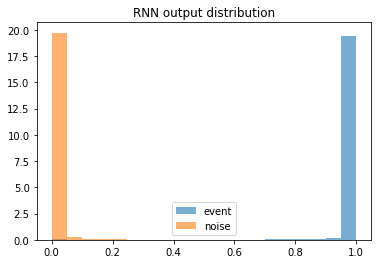

In [62]:
cl5.plot_output_distribution()

Total signal events: 20045 Total noise events: 59855


/content/RNNBinaryClassifier.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  nr.append(np.log10(1.0/(1.0 - correct_noise_events/NN)))


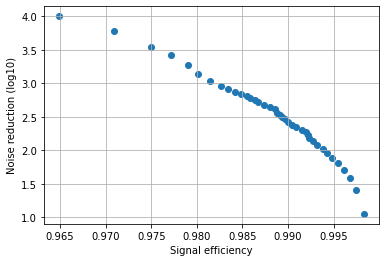

In [63]:
cl5.plot_signal_eff_vs_noise_red()

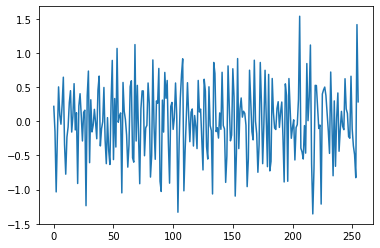

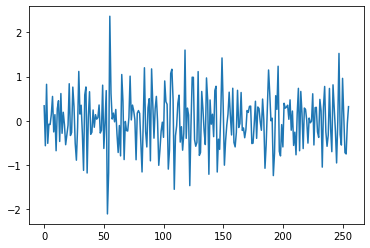

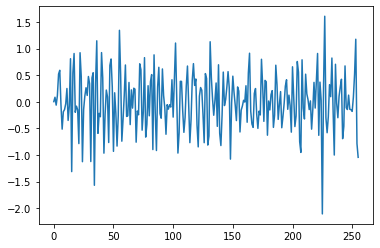

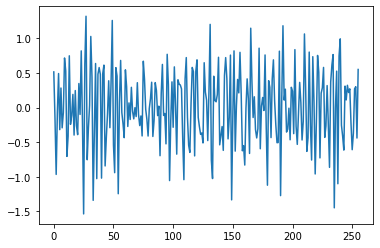

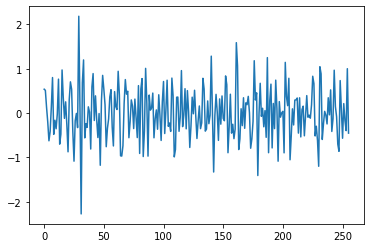

Logit output: [[-6.3267884]]
True label: [[0.]]



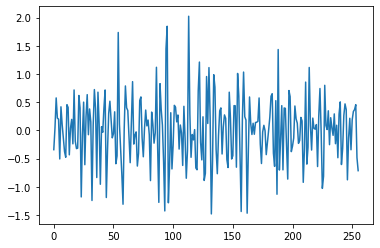

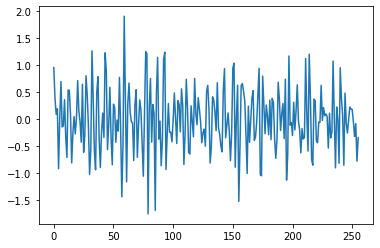

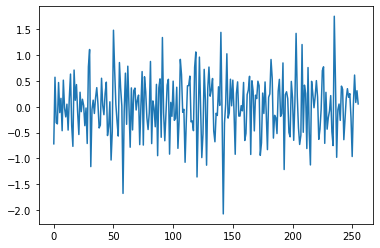

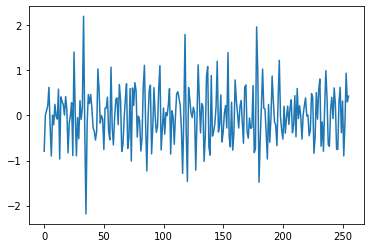

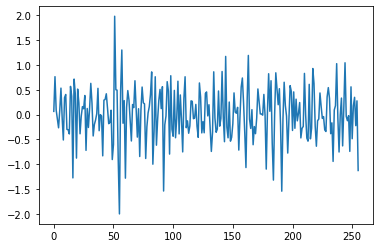

Logit output: [[-4.5544806]]
True label: [[0.]]



In [64]:
cl5.plot_samples(n_samples=2)

In [ ]:
#torch.save(cl.trainer.best_model.state_dict(), "best_model_ARIANNA_1CH_100_batch.dict")